# Define



Now that the initial hypothesis has been defined, we can focus on the following questions in the define phase:
- What matters most?
    - The cleaning and imputation of missing values in the data is essential for informing our modelling
- What is feasible?
    - What can be done that will be possible in short computation times

The number 1 goal to keep in mind in the define phase is that we are defining a product around a user, not programming a user around a product.

#### 0. Data Collection & Analysis

Data was gathered from [SEAI](https://ndber.seai.ie/BERResearchTool/ber/search.aspx) who had a valid characteristics accounted for.

This now sets up the body of work aligned with the define phase of this thesis.

Dwelling dimensions, orientation, 
ventilation, dwelling fabric, water heating, lighting, space heating, heating controls and 
fuel type influence the building energy rating and must all be considered when 
determining the actual rating and where potential improvements could be made.

In [54]:
# Read in libraries needed for analysis
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Leaves all pandas calculations to 2 decimal places to avoid SN
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from MissForestExtra import MissForestExtra

# Set a random seed so analysis is replicable
random.seed(2814)

In [55]:
# Pull in the SEAI dataset to use for analysis
seai = pd.read_table( 
    '../data/external/BERPublicSearch/BERPublicsearch.txt'
    ,usecols=[  'CountyName'
              , 'DwellingTypeDescr'
              , 'Year_of_Construction'
              , 'GroundFloorArea(sq m)'
              , 'EnergyRating'
              , 'BerRating'
              , 'CO2Rating'
              , 'TotalDeliveredEnergy'
              , 'InsulationType'
              , 'InsulationThickness'
              , 'MainSpaceHeatingFuel'
              , 'MainWaterHeatingFuel'
              , 'NoOfSidesSheltered'
              , 'StructureType'
              , 'VentilationMethod']
    ,encoding = 'Latin-1'
)

In [56]:
# High level overview of the dataset
seai

,CountyName,DwellingTypeDescr,Year_of_Construction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Co. Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Co. Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Co. Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
3,Dublin 11,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,NaN,NaN,22708.48
4,Dublin 22,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043905,Co. Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,NaN,NaN,52927.53
1043906,Dublin 6,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,4.00,NaN,NaN,NaN
1043907,Dublin 1,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,2.00,NaN,NaN,NaN
1043908,Dublin 1,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,4.00,NaN,NaN,NaN


In [57]:
# Get rid of all underscores to avoid issues later with encoding with dummy variables
seai.columns = seai.columns.str.replace('_', '')

In [58]:
# Taking a look at the SEAI dataset numerical columns
seai.describe()

,YearofConstruction,BerRating,GroundFloorArea(sq m),CO2Rating,NoOfSidesSheltered,InsulationThickness,TotalDeliveredEnergy
count,1043910.00,1043910.00,1043910.00,1043910.00,1040297.00,811123.00,445800.00
mean,1983.79,234.55,114.01,54.56,2.31,31.62,24085.64
std,33.78,172.78,59.76,48.60,1.05,23.81,23306.38
min,1753.00,-158.42,5.47,-258.25,0.00,0.00,-3929.79
25%,1973.00,153.64,77.92,32.46,2.00,25.00,14844.80
50%,1997.00,207.08,100.30,46.25,2.00,30.00,21027.03
75%,2005.00,282.32,133.71,65.13,3.00,40.00,29315.55
max,2104.00,56423.71,3546.11,18417.10,4.00,1872.00,5431169.68


In [59]:
# Check the datatypes for each column and determine if they are correct or not
seai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043910 entries, 0 to 1043909
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   CountyName             1043910 non-null  object 
 1   DwellingTypeDescr      1043910 non-null  object 
 2   YearofConstruction     1043910 non-null  int64  
 3   EnergyRating           1043910 non-null  object 
 4   BerRating              1043910 non-null  float64
 5   GroundFloorArea(sq m)  1043910 non-null  float64
 6   CO2Rating              1043910 non-null  float64
 7   MainSpaceHeatingFuel   1028262 non-null  object 
 8   MainWaterHeatingFuel   1028262 non-null  object 
 9   VentilationMethod      1040297 non-null  object 
 10  StructureType          1040297 non-null  object 
 11  NoOfSidesSheltered     1040297 non-null  float64
 12  InsulationType         811123 non-null   object 
 13  InsulationThickness    811123 non-null   float64
 14  TotalDeliveredEner

In [60]:
# Create a pandas profile report
profile = ProfileReport(seai, title="SEAI Ingested Data Report ", explorative=True)
# Output the report to a html file to view
profile.to_file("../reports/Define/1-seai_profile_report_raw.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 235.52it/s]


A few issues have arisen based on the initial observation of the data above:
- The dataset overview shows that the `CountyName` column has 'Co.' with each county and Dublin is split into numerical districts. Both need to be removed.
    - Done
- The description report shows the max year of construction is 2104. The max needs to be amended to be 2022.
    - Done
- The description report shows we have 57.3% missing values for `TotalDeliveredEnergy` column. This will need to be dropped at a minimum.
    - Done
- The description report shows that the min for `BerRating`, `CO2Rating` and `TotalDeliveredEnergy` are negative. This could be bad data or indication of a good BER rating. Needs to be investigated and dealt with.
    - Done
- The `EnergyRating` column is an object, it should be an ordered factor.
    - Done
- Change the `StructureType` value of 'Please Select' to NaN to be imputed later as this is a blank.
    - Done
- There are duplicates being accounted for on some entries that must be removed.
    - Done
- Investigate the nulls for:
    - `MainSpaceHeatingFuel`
    - `MainWaterHeatingFuel`
    - `VentilationMethod`
    - `StructureType`
    - `NoOfSidesSheltered`
    - `InsulationType`
    - `InsulationThickness`
    - `TotalDeliveredEnergy`
- The investiation should involve looking at
    - Where are the nulls?
    - Is there a commonality with other values for these nulls?
    - Is there coversely no discernible pattern?
    - Is there a structural flaw?

Note that I am not worried about the very high BerRating and CO2Rating maxiumums as they make sense when the data is examined.

### 1. Data Cleaning

#### 1.1 County Cleaning

In [61]:
# Removal of 'Co.' and numerical items from CountyName column
seai['CountyName'] = seai['CountyName'].str.replace('Co. ', '') # Removes all occurrences of Co.
seai['CountyName'] = seai['CountyName'].str.replace('City', '') # Removes all occurrences of City
seai['CountyName'] = seai['CountyName'].str.replace('\d+', '') # Removes all digits
seai['CountyName'] = seai['CountyName'].str.replace('Dublin W', 'Dublin') # Removes occurence of W after Dublin
seai['CountyName'] = seai['CountyName'].str.strip() # Removes any blankspace left after cleaning
# Checking out the column to see if changes have worked
print(seai['CountyName'].unique())
# Printing some lines between the two results for clarity
print('--------------------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------------------')
# Checking to see if the length is 26 (Number of counties in Republic of Ireland)
print(len(seai['CountyName'].unique()))

['Donegal' 'Kildare' 'Dublin' 'Limerick' 'Kerry' 'Kilkenny' 'Cork'
 'Wexford' 'Carlow' 'Galway' 'Louth' 'Offaly' 'Sligo' 'Wicklow' 'Clare'
 'Tipperary' 'Monaghan' 'Mayo' 'Laois' 'Westmeath' 'Roscommon' 'Meath'
 'Leitrim' 'Cavan' 'Waterford' 'Longford']
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
26


In [62]:
# Convert from string to category
seai['CountyName'] = seai['CountyName'].astype('category')

---

#### 1.2 Year of Construction Cleaning

<AxesSubplot:xlabel='YearofConstruction', ylabel='Count'>

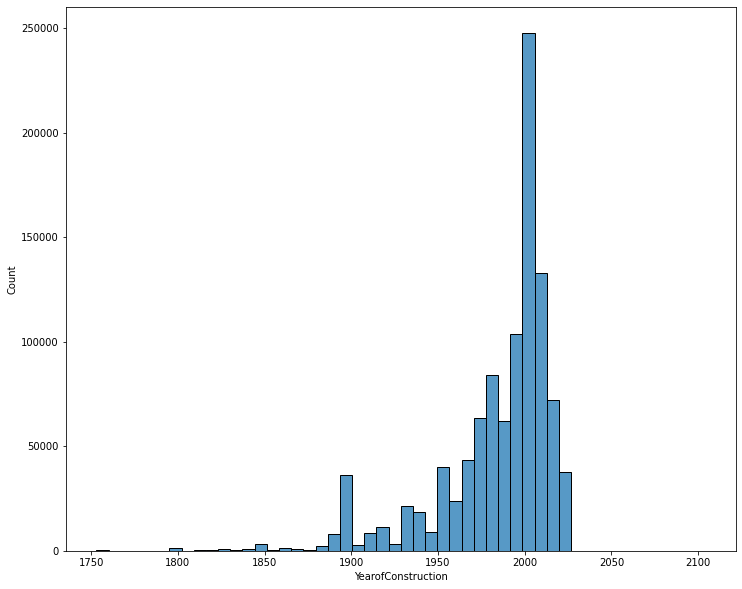

In [63]:
# Checking distribution of years of house builds
plt.figure(figsize=(12,10))
sns.histplot(data=seai
            ,x='YearofConstruction'
            ,bins=50)

We can clearly see from above 2104 as a year is a once off error and can be removed

In [64]:
seai

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,NaN,NaN,22708.48
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043905,Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,NaN,NaN,52927.53
1043906,Dublin,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,4.00,NaN,NaN,NaN
1043907,Dublin,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,2.00,NaN,NaN,NaN
1043908,Dublin,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,4.00,NaN,NaN,NaN


In [65]:
# Removal of bad year entry in data
seai = seai[seai['YearofConstruction'] <= 2022]

<AxesSubplot:xlabel='YearofConstruction', ylabel='Count'>

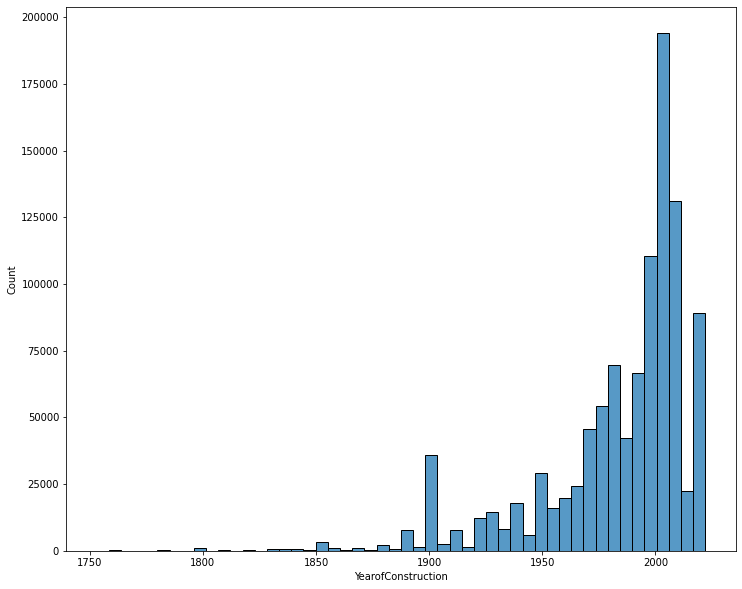

In [66]:
plt.figure(figsize=(12,10))
sns.histplot(data=seai
            ,x='YearofConstruction'
            ,bins=50)

In [37]:
seai

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,NaN,NaN,22708.48
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043905,Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,NaN,NaN,52927.53
1043906,Dublin,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,4.00,NaN,NaN,NaN
1043907,Dublin,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,2.00,NaN,NaN,NaN
1043908,Dublin,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,4.00,NaN,NaN,NaN


In [12]:
# Convert from string to category
seai['YearofConstruction'] = seai['YearofConstruction'].astype('category')

---

#### 1.3 CO2 Rating Cleaning

In [13]:
# Checking out the distribution of values where we have negative in the 2 columns.
seai[['EnergyRating', 'CO2Rating']][(seai[['BerRating']] < 0).all(1) | 
                                    (seai[['CO2Rating']] < 0).all(1)].groupby('EnergyRating').count()

,CO2Rating
EnergyRating,
A1,167
A2,12
A3,12
B1,8
B2,8
B3,5
C1,6
C2,4
C3,1


Interestingly we have people who have lower bounds of energy ratings but still negative CO2 emissions somehow. Perhaps these people have solar panelling but their house rating is simply just poorer. 

The majority of houses with negative emissions are A1 rated which makes sense to what I would have thought the cause to be if these values were not poor data.

I will remove any below a B2 rating as I do not see logically other than solar panelling how this would occur. Regardless these people will skew the data and as such need to be accounted for.

In [14]:
# Identify all entries that qualify for removal as above and save them to a new dataframe
seai_to_drop = seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) | 
                                                                                             (seai[['CO2Rating']] < 0).all(1)
                                                                                            ]
# Drop these index entries from our original dataframe
seai = seai.drop(seai_to_drop.index)
# Delete the now redundant index dataframe
del(seai_to_drop)

In [15]:
# Check to see if these entries were dropped correctly. Should produce 0 rows
seai[seai['EnergyRating'].map(lambda x: x in ['B2', 'B3', 'C1', 'C2', 'C3'])][(seai[['BerRating']] < 0).all(1) | 
                                                                              (seai[['CO2Rating']] < 0).all(1)
                                                                             ]

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy


---

#### 1.4 Energy Rating Cleaning

In [16]:
# Remove any blank space
seai['EnergyRating'] = seai['EnergyRating'].str.strip()
# Changing the datatype of the EnergyRating column
seai['EnergyRating'] = seai['EnergyRating'].astype('category')
# Reorder categories in order of how good they are descending
seai['EnergyRating'] = seai['EnergyRating'].cat.reorder_categories(['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G'])

In [17]:
# Checking the work above is correct
seai['EnergyRating'].unique()

['C2', 'B3', 'C3', 'D2', 'D1', ..., 'B2', 'B1', 'A3', 'A2', 'A1']
Length: 15
Categories (15, object): ['A1', 'A2', 'A3', 'B1', ..., 'E1', 'E2', 'F', 'G']

<AxesSubplot:xlabel='EnergyRating', ylabel='count'>

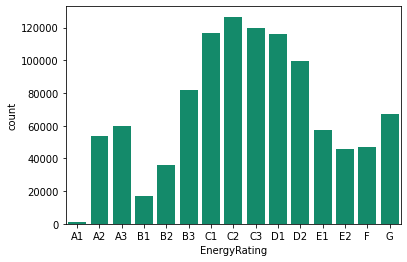

In [18]:
# Checking the distribution of BER values across the dataset
sns.countplot(
             data=seai
            ,x='EnergyRating'
            ,order=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G']
            ,color='#009E73')

---

#### 1.5 Structure Type Cleaning

In [19]:
# Get all the unique values
seai.StructureType.unique()

array(['Masonry                       ', 'Timber or Steel Frame         ',
       'Please select                 ', 'Insulated Conctete Form       ',
       nan], dtype=object)

In [20]:
# Remove redundant 'Please Select' entry in StructureType column 
seai['StructureType'] = seai['StructureType'].replace('Please select                 ', np.nan)
# Clean the other column values
seai['StructureType'] = seai['StructureType'].replace('Masonry                       ', 'Masonry')
seai['StructureType'] = seai['StructureType'].replace('Timber or Steel Frame         ', 'Timber or Steel Frame')
seai['StructureType'] = seai['StructureType'].replace('Insulated Conctete Form       ', 'Insulated Conctete Form')

In [21]:
# Check if the above was successful
seai.StructureType.unique()

array(['Masonry', 'Timber or Steel Frame', nan, 'Insulated Conctete Form'],
      dtype=object)

---

#### 1.6 Duplicate Cleaning

In [22]:
seai

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,NaN,NaN,22708.48
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043905,Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,NaN,NaN,52927.53
1043906,Dublin,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,4.00,NaN,NaN,NaN
1043907,Dublin,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,2.00,NaN,NaN,NaN
1043908,Dublin,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,4.00,NaN,NaN,NaN


In [23]:
# Drop all duplicates in the dataset and keep the first entry of each
seai = seai.drop_duplicates(keep='first')

In [24]:
seai

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
3,Dublin,Semi-detached house,1965,C2,196.99,138.41,37.83,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,NaN,NaN,22708.48
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043905,Donegal,Detached house,1982,D2,282.58,214.18,70.89,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,NaN,NaN,52927.53
1043906,Dublin,Mid-terrace house,1900,G,998.14,99.77,317.99,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,4.00,NaN,NaN,NaN
1043907,Dublin,Mid-floor apartment,2021,A2,37.26,81.32,7.33,NaN,NaN,Whole house extract vent.,Masonry,2.00,NaN,NaN,NaN
1043908,Dublin,Mid-floor apartment,2022,A2,36.05,82.09,6.76,NaN,NaN,Bal.whole mech.vent heat recvr,Masonry,4.00,NaN,NaN,NaN


---

#### 1.7 Dwelling Type Description Cleaning

In [23]:
# Change from a string to a category
seai['DwellingTypeDescr'] = seai['DwellingTypeDescr'].astype('category')

---


#### 1.8 Nulls analysis

##### 1.8.1 - `MainSpaceHeatingFuel`

In [24]:
# Remove any whitespace in column
seai['MainSpaceHeatingFuel'] = seai['MainSpaceHeatingFuel'].str.strip()

In [25]:
# Check out any unique values
seai['MainSpaceHeatingFuel'].unique()

array(['Heating Oil', 'Mains Gas', 'Electricity', 'Solid Multi-Fuel',
       'Sod Peat', 'Bulk LPG (propane or butane)', 'House Coal', nan,
       'Wood Logs', 'Bottled LPG', 'Peat Briquettes',
       'Wood Pellets (bulk supply for', 'Electricity - Standard Domesti',
       'Wood Pellets (in bags for seco', 'Manufactured Smokeless Fuel',
       'Anthracite', 'Wood Chips', 'Electricity - Off-peak Night-R',
       'Electricity - On-peak Night-Ra', 'Bioethanol from renewable sour',
       'Biodiesel from renewable sourc'], dtype=object)

In [26]:
# Examination of the other columns in the case where or target is null
seai[seai['MainSpaceHeatingFuel'].isna()]['MainWaterHeatingFuel'].value_counts(dropna=False)

# 14k missing
# 12k also have missing energy delivered
# Every row has water heating missing too
# Mainly missing in A rated homes - may be due no solar panel option?

# This is MNAR

NaN    14110
Name: MainWaterHeatingFuel, dtype: int64

##### 1.8.2 `MainWaterHeatingFuel`

In [27]:
# Remove any whitespace in column
seai['MainWaterHeatingFuel'] = seai['MainWaterHeatingFuel'].str.strip()

In [28]:
# Check out any unique values
seai['MainWaterHeatingFuel'].unique()

array(['Heating Oil', 'Mains Gas', 'Electricity', 'Sod Peat',
       'Solid Multi-Fuel', 'Bulk LPG (propane or butane)', 'House Coal',
       nan, 'Bottled LPG', 'Wood Logs', 'Peat Briquettes',
       'Wood Pellets (bulk supply for', 'Wood Pellets (in bags for seco',
       'Manufactured Smokeless Fuel', 'Anthracite', 'Wood Chips',
       'Bioethanol from renewable sour', 'Electricity - Standard Domesti',
       'Electricity - Off-peak Night-R', 'Electricity - On-peak Night-Ra',
       'Biodiesel from renewable sourc', 'None'], dtype=object)

In [29]:
# Examination of the other columns in the case where or target is null
seai[seai['MainWaterHeatingFuel'].isna()]['EnergyRating'].value_counts(dropna=False)

# Same 12k missing from before
# Other heating column also missing everywhere this feature is
# Same distribution of BER ratings as before

# This feature is MNAR

A2    3620
A3    2634
B3    1120
B2     924
C1     851
G      814
C2     693
D1     669
C3     658
B1     584
D2     487
F      424
E1     319
E2     309
A1       4
Name: EnergyRating, dtype: int64

##### 1.8.3 `VentilationMethod`

In [30]:
# Remove any whitespace in column
seai['VentilationMethod'] = seai['VentilationMethod'].str.strip()

In [31]:
# Check out any unique values
seai['VentilationMethod'].unique()

array(['Natural vent.', 'Bal.whole mech.vent heat recvr',
       'Bal.whole mech.vent no heat re', 'Pos input vent.- loft',
       'Pos input vent.- outside', 'Whole house extract vent.', nan],
      dtype=object)

In [32]:
# Examination of the other columns in the case where or target is null
seai[seai['VentilationMethod'].isna()]['EnergyRating'].value_counts(dropna=False)

# Only 2k missing from energy delivered
# Other heating column also missing everywhere this feature is
# Missing quite a lot in the A categories - Is this because they do not need vents?
# Missing a lot of values for electricity based houses
# All structure types associated are NaN
# No insulation captured
# No side sheltered captured

# This feature is MNAR

A2    1933
A3     835
B3      25
B1      20
B2      18
A1      14
C1      14
G       11
C2      10
C3       7
E2       5
D1       4
D2       3
F        2
E1       0
Name: EnergyRating, dtype: int64

##### 1.8.4 `StructureType`

In [33]:
# Check out any unique values
seai['StructureType'].unique()

array(['Masonry', 'Timber or Steel Frame', nan, 'Insulated Conctete Form'],
      dtype=object)

In [34]:
# Examination of the other columns in the case where or target is null
seai[seai['StructureType'].isna()]['InsulationType'].value_counts(dropna=False)

# Huge amount of A rated homes missing values
# 70k energy delivered missing for structure type
# Most of these NaN values are due to simple non selection upon entry into database
# 40k missing for electricity customers, 24k for mains gas on main space heating fuel
# Coincides with 40k missing Insulation rows too

# This feature is MNAR

NaN                               39772
Factory Insulated                 18261
None                              13544
Loose Jacket                        699
Name: InsulationType, dtype: int64

##### 1.8.5 `NoOfSidesSheltered`

In [35]:
# Check out any unique values
seai['NoOfSidesSheltered'].unique()

array([ 1.,  2.,  3.,  4.,  0., nan])

In [36]:
# Examination of the other columns in the case where or target is null
seai[seai['NoOfSidesSheltered'].isna()]['InsulationType'].value_counts(dropna=False)

# Heating oil houses are generally much more abundant in missing values
# Missing values distributed evenly over the BER ratings
# Masonry structures have 58k missing values

# This is MNAR

NaN    2901
Name: InsulationType, dtype: int64

In [37]:
# Make changes to make this categorical
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(0, 'zero')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(1, 'one')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(2, 'two')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(3, 'three')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].replace(4, 'four')
seai['NoOfSidesSheltered'] = seai['NoOfSidesSheltered'].astype('category')
seai['YearofConstruction'] = seai['YearofConstruction'].astype('category')

##### 1.8.6 `InsulationType`

In [38]:
# Remove any whitespace in column
seai['InsulationType'] = seai['InsulationType'].str.strip()

In [39]:
# Check out any unique values
seai['InsulationType'].unique()

array(['Factory Insulated', 'Loose Jacket', nan, 'None'], dtype=object)

In [40]:
# Examination of the other columns in the case where or target is null
seai[seai['InsulationType'].isna()]['StructureType'].value_counts(dropna=False)

# Missing values distributed across BER - A has highest
# 78k mains gas missing, 66k oil, 64k electricity
# 170k masonry values missing 

# MNAR

Masonry                    170721
NaN                         39772
Timber or Steel Frame       10234
Insulated Conctete Form       366
Name: StructureType, dtype: int64

##### 1.8.6 `InsulationThickness`

In [41]:
# Examination of the other columns in the case where or target is null
seai[seai['InsulationThickness'].isna()]['EnergyRating'].value_counts(dropna=False)

# Missing values distributed across BER - G has highest
# 121k mains gas missing, 100k oil, 96k electricity
# 274k masonry values missing 
# 242k missing energy delivered our of 343k


# MNAR

A2    30912
C1    23984
C2    22883
B3    21452
C3    20148
D1    17722
A3    15272
D2    14908
G     11939
B2    11637
E1     8715
F      7389
E2     6884
B1     6168
A1     1080
Name: EnergyRating, dtype: int64

##### 1.8.9 `TotalDeliveredEnergy`

In [42]:
# Make any nonsense values into NaN
seai['TotalDeliveredEnergy'] = seai['TotalDeliveredEnergy'].replace(0, np.nan)

In [43]:
# Examination of the other columns in the case where or target is null
seai[seai['TotalDeliveredEnergy'].isna()]['StructureType'].value_counts(dropna=False)

# Missing values distributed across BER - C has highest
# 235k mains gas missing, 137k oil, 164k electricity
# 460k masonry values missing 

# MNAR

Masonry                    460682
NaN                         69644
Timber or Steel Frame       36924
Insulated Conctete Form      3198
Name: StructureType, dtype: int64

---

#### 1.10 Results

In [45]:
# Reset index so it is not included in report putput
seai.reset_index(drop=True, inplace=True)
# Create a pandas profile report
profile_optimised = ProfileReport(seai, title="SEAI Data With Nulls & Cleaned - Report", explorative=True)
# Output the report to a html file to view
profile_optimised.to_file("../reports/Define/2-seai_with_nulls_cleaned_profile_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 270.20it/s]


In [69]:
# Write our data to be used in design phase
seai.to_csv('../data/interim/Define/1-seai_with_nulls_cleaned.csv', index=False)

The new generated report shows we have:
- No duplicate rows
- All fixes made above implemented correctly
- There are clearly string size limits in the boxes when the data was collected

---

### 2. Total Delivered Energy Imputation

#### 2.1 Ideation

In [44]:
# Taking a look at the SEAI dataset numerical columns
seai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005348 entries, 0 to 1043909
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   CountyName             1005348 non-null  category
 1   DwellingTypeDescr      1005348 non-null  category
 2   YearofConstruction     1005348 non-null  category
 3   EnergyRating           1005348 non-null  category
 4   BerRating              1005348 non-null  float64 
 5   GroundFloorArea(sq m)  1005348 non-null  float64 
 6   CO2Rating              1005348 non-null  float64 
 7   MainSpaceHeatingFuel   991238 non-null   object  
 8   MainWaterHeatingFuel   991238 non-null   object  
 9   VentilationMethod      1002447 non-null  object  
 10  StructureType          933072 non-null   object  
 11  NoOfSidesSheltered     1002447 non-null  category
 12  InsulationType         784255 non-null   object  
 13  InsulationThickness    784255 non-null   float64 
 14  To

I want to model out the `TotalDeliveredEnergy` missing values to account for them using a regression based imputation

To start with, what is the TotalDeliveredEnergy column in terms of the null values
    - We are going to assume it is MCAR and then MAR
        - MCAR means we can remove it 
        - MAR means we can impute it
    
To start: We go from simple to advanced
- Simply remove these records from the analysis altogether
- Impute mean and mode for each groupby
- MissForest Imputation
- MICE (No Python package for this needs to be done in R)

Each cleaned imputed dataset should be saved in the data/interim folder under specific names to pull back into the design phase for modelling.

---

##### 2.1.1 Drop All Null Values

In [38]:
# Drop all NaN across entire df
seai_dropped_na = seai.dropna()

In [39]:
seai_dropped_na

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
0,Donegal,Detached house,1997,C2,180.01,171.19,45.53,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Factory Insulated,20.00,25474.52
1,Kildare,Detached house,2010,B3,137.56,242.93,35.66,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,50.00,27654.47
2,Dublin,Semi-detached house,1999,C3,223.61,99.38,44.65,Mains Gas,Mains Gas,Natural vent.,Masonry,3.00,Loose Jacket,20.00,17000.04
4,Dublin,Semi-detached house,1985,D2,260.52,127.16,55.07,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,Loose Jacket,100.00,28182.86
5,Donegal,House,1975,D1,248.00,88.57,62.68,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,0.00,18470.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043575,Dublin,End of terrace house,1979,D1,253.97,81.74,51.64,Mains Gas,Mains Gas,Natural vent.,Masonry,2.00,None,0.00,16038.84
1043576,Wicklow,Detached house,1996,C3,205.92,78.81,50.29,Heating Oil,Heating Oil,Natural vent.,Masonry,2.00,Factory Insulated,35.00,13208.40
1043587,Roscommon,Detached house,1990,D1,250.38,118.09,62.88,Heating Oil,Heating Oil,Natural vent.,Masonry,0.00,Factory Insulated,35.00,25420.30
1043588,Donegal,Detached house,1998,D2,274.33,114.30,69.24,Heating Oil,Heating Oil,Natural vent.,Masonry,1.00,Loose Jacket,60.00,26317.08


In [46]:
# Write to interim files so we can model in design phase
seai_dropped_na.to_csv('../data/interim/Define/scenario1_seai_dropped_na.csv', index=False)

##### 2.1.2 Impute using mean and mode for groupby

In [47]:
# Create a copy of our data to work with without overwriting the original
seai_mean_mode_imputation = seai.copy()

In [48]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['YearofConstruction'].isna(), 'YearofConstruction'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ]
        )['YearofConstruction'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [49]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['NoOfSidesSheltered'].isna(), 'NoOfSidesSheltered'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ]
        )['NoOfSidesSheltered'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [50]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['MainSpaceHeatingFuel'].isna(), 'MainSpaceHeatingFuel'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ]
        )['MainSpaceHeatingFuel'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [51]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['MainWaterHeatingFuel'].isna(), 'MainWaterHeatingFuel'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ]
        )['MainWaterHeatingFuel'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [52]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['MainWaterHeatingFuel'].isna(), 'MainWaterHeatingFuel'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ]
        )['MainWaterHeatingFuel'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [53]:
# Impute the modal values based on County, Dwelling Type and Energy Rating
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['VentilationMethod'].isna(), 'VentilationMethod'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ,'MainWaterHeatingFuel'
            ]
        )['VentilationMethod'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [54]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['StructureType'].isna(), 'StructureType'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ,'MainWaterHeatingFuel'
            ,'VentilationMethod'
            ]
        )['StructureType'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [55]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['InsulationType'].isna(), 'InsulationType'] = seai_mean_mode_imputation.groupby(
        [
            'CountyName'
            ,'DwellingTypeDescr'
            ,'EnergyRating'
            ,'MainSpaceHeatingFuel'
            ,'MainWaterHeatingFuel'
            ,'VentilationMethod'
            ,'StructureType'
            ]
        )['InsulationType'].transform(
            lambda x: x.mode()[0] if any(x.mode()) else 'ALL_NAN'
            )

In [56]:
# Replace the values we could not impute with the overall column mode
seai_mean_mode_imputation['InsulationType'] = seai_mean_mode_imputation['InsulationType'].replace('ALL_NAN', 'Factory Insulated')

In [57]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['InsulationThickness'].isna(), 'InsulationThickness'] = seai_mean_mode_imputation.groupby(
        [
            'CO2Rating'
            ]
        )['InsulationThickness'].transform(
            lambda x: x.fillna(x.mean())
            )

In [58]:
# Replace anywhere we have no insulation with 0 so we don't have nonsene data
seai_mean_mode_imputation.loc[seai_mean_mode_imputation['InsulationType'] == 'None', 'InsulationThickness'] = 0

In [59]:
# Impute the modal values based on grouped columns
seai_mean_mode_imputation.loc[
    seai_mean_mode_imputation['TotalDeliveredEnergy'].isna(), 'TotalDeliveredEnergy'] = seai_mean_mode_imputation.groupby(
        [
            'EnergyRating',  
            ]
        )['TotalDeliveredEnergy'].transform(
            lambda x: x.fillna(x.mean())
            )

In [65]:
# Remove any underlying NA data
seai_mean_mode_imputation = seai_mean_mode_imputation.dropna()

In [66]:
# Check for any nulls left
seai_mean_mode_imputation.isna().sum()

CountyName               0
DwellingTypeDescr        0
YearofConstruction       0
EnergyRating             0
BerRating                0
GroundFloorArea(sq m)    0
CO2Rating                0
MainSpaceHeatingFuel     0
MainWaterHeatingFuel     0
VentilationMethod        0
StructureType            0
NoOfSidesSheltered       0
InsulationType           0
InsulationThickness      0
TotalDeliveredEnergy     0
dtype: int64

In [67]:
seai_mean_mode_imputation=seai_mean_mode_imputation.drop_duplicates(keep='first')

In [68]:
# Write to interim files so we can model in design phase
seai_mean_mode_imputation.to_csv('../data/interim/Define/scenario2_seai_mean_mode_imputation.csv', index=False)

In [78]:
seai_cleaned_results[seai['EnergyRating'] == 'A1']

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,Imputed_Forest,Imputed_GroupByMeanMode
131873,Clare,Detached house,1940,A1,-2.03,286.00,-0.60,Electricity,Electricity,Natural vent.,Masonry,one,Factory Insulated,50.00,NaN,16007.72,2451.81
135252,Kilkenny,Detached house,2014,A1,20.75,272.68,4.70,Electricity,Electricity,Bal.whole mech.vent heat recvr,NaN,two,None,0.00,NaN,17090.55,2451.81
136927,Roscommon,Detached house,2013,A1,-63.96,153.97,-14.49,Electricity,Electricity,Bal.whole mech.vent heat recvr,NaN,two,Factory Insulated,75.00,NaN,19354.32,2451.81
158600,Louth,Detached house,2014,A1,-10.05,228.00,-2.65,Electricity,Electricity,Bal.whole mech.vent heat recvr,NaN,zero,Factory Insulated,50.00,NaN,14632.36,2451.81
199940,Cork,Detached house,2015,A1,18.94,169.35,2.70,Mains Gas,Mains Gas,Bal.whole mech.vent heat recvr,NaN,two,Factory Insulated,50.00,NaN,12463.14,2451.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039357,Kildare,End of terrace house,2022,A1,21.66,104.08,4.26,Electricity,Electricity,Whole house extract vent.,Masonry,two,NaN,NaN,NaN,NaN,2451.81
1041920,Westmeath,Detached house,2019,A1,12.71,143.36,2.50,Electricity,Electricity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2451.81
1042710,Dublin,Detached house,2020,A1,22.46,181.79,4.42,Electricity,Electricity,Bal.whole mech.vent heat recvr,NaN,zero,NaN,NaN,NaN,NaN,2451.81
1042756,Dublin,Detached house,2021,A1,21.87,223.50,4.30,Electricity,Electricity,Bal.whole mech.vent heat recvr,NaN,three,NaN,NaN,NaN,NaN,2451.81


---

##### 2.1.3 MissForest

MissForest is a machine learning-based imputation technique. It uses a Random Forest algorithm to do the task. It is based on an iterative approach, and at each iteration the generated imputations are better.
Unlike KNN, MissForest doesn’t care about the scale of the data and doesn’t require tuning. It is easier to use out of the box, but that doesn’t mean the results will be better.
Advantages: It doesn’t require data preparation, as the Random Forest algorithm can determine which features are important for imputation. It doesn’t require tuning, and can handle categorical variables.
Disadvantages: It can be computationally expensive when working with large datasets.

https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3

In [ ]:
from MissForestExtra import MissForestExtra
mfe = MissForestExtra()
seai_imputed = mfe.impute(seai, RandomForestClassifier(), RandomForestRegressor())

In [88]:
seai_imputed.to_csv('../data/processed/Define/seai_missingforest_data_imputed.csv', index=False)

In [73]:
seai_imputed = pd.read_csv('../data/processed/Define/seai_missingforest_data_imputed.csv')

In [70]:
seai_imputed = seai_imputed.drop_duplicates(keep='first')

In [79]:
seai_imputed.isna()

,CountyName,DwellingTypeDescr,YearofConstruction,GroundFloorArea(sq m),MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,EnergyRating
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951816,False,False,False,False,False,False,False,False,False,False,False,False,False
951817,False,False,False,False,False,False,False,False,False,False,False,False,False
951818,False,False,False,False,False,False,False,False,False,False,False,False,False
951819,False,False,False,False,False,False,False,False,False,False,False,False,False


I want to be able to evaluate the MissForest algorithm so I know everything worked ok.

To do this, I can simply nullify some of the columns in my original dataset with a set index, perform the algorithm on this and see how it performs relative to them when I resolve the nulls I have created artificially

In [90]:
seai_cleaned_results = seai.copy()
seai_cleaned_results['Imputed_Forest'] = seai_imputed['TotalDeliveredEnergy']
seai_cleaned_results['Imputed_GroupByMeanMode'] = seai_mean_mode_imputation['TotalDeliveredEnergy']
seai_cleaned_results['DroppedNA'] = seai_dropped_na['TotalDeliveredEnergy']

In [96]:
seai_cleaned_results.groupby('EnergyRating').agg(['count'])[['TotalDeliveredEnergy', 'DroppedNA','Imputed_GroupByMeanMode', 'Imputed_Forest']]

,TotalDeliveredEnergy,DroppedNA,Imputed_GroupByMeanMode,Imputed_Forest
,count,count,count,count
EnergyRating,,,,
A1,33,3,757,1217
A2,169,71,43019,39775
A3,1672,865,51168,47927
B1,3359,2608,15248,13279
B2,8753,7385,32804,28281
B3,22759,19648,77952,68584
C1,40083,34849,113773,102252
C2,54909,47825,124525,113395


In [98]:
seai.EnergyRating.value_counts(dropna=False).sort_index()

A1      1258
A2     43242
A3     51194
B1     15261
B2     32814
B3     77970
C1    113782
C2    124530
C3    118185
D1    114352
D2     98187
E1     56631
E2     44780
F      46347
G      66815
Name: EnergyRating, dtype: int64

In [80]:
seai.TotalDeliveredEnergy.value_counts(dropna=False)

NaN         570448
184.70          22
641.72          16
184.88          14
541.27          12
             ...  
17043.06         1
11203.73         1
19404.59         1
9128.95          1
52927.53         1
Name: TotalDeliveredEnergy, Length: 431408, dtype: int64

The results are interesting. 
- The means and medians are about 2k less most of the time, except for the A rated classes

---

#### 2.4 Assessment of Imputation as a tool

In [3]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [4]:
import pandas as pd
seai = pd.read_csv('../data/interim/Define/1-seai_with_nulls_cleaned.csv')

In [5]:
df_sample = seai[~seai.isnull().any(axis=1)]


df_sample = stratified_sample_df(df_sample, 'EnergyRating', 100)

df_sample_copy = df_sample.copy()

In [6]:
df_sample

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
200087,Kilkenny,House,2008,A1,19.52,101.57,4.65,Electricity - Off-peak Night-R,Electricity - Off-peak Night-R,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,734.44
517487,Wexford,House,2014,A1,14.03,348.40,3.15,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,80.00,8640.90
533472,Cork,House,2009,A1,24.43,224.22,0.59,Wood Pellets (bulk supply for,Wood Pellets (bulk supply for,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,2251.86
37121,Galway,House,2011,A2,49.04,222.16,11.28,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,zero,Factory Insulated,50.00,5022.15
532561,Carlow,Apartment,2005,A2,35.69,48.33,8.50,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,699.26
533294,Galway,Detached house,2009,A2,47.90,259.90,11.66,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,50.00,7998.44
566180,Dublin,Semi-detached house,2017,A3,52.19,115.37,10.26,Electricity,Electricity,Natural vent.,Timber or Steel Frame,two,Factory Insulated,0.00,2894.63
552041,Wexford,Semi-detached house,2010,A3,66.24,118.32,15.06,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Timber or Steel Frame,one,Factory Insulated,50.00,5874.35
169642,Dublin,Detached house,1930,A3,69.02,340.83,16.13,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,12122.33
219912,Dublin,Mid-terrace house,2009,B1,89.11,127.72,17.41,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Factory Insulated,50.00,9254.50


In [7]:
r4 = random.sample(range(len(df_sample)),12)
df_sample['TotalDeliveredEnergy'] = [val if i not in r4 else np.nan for i, val in enumerate(df_sample['TotalDeliveredEnergy'])]

In [8]:
df_sample

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy
200087,Kilkenny,House,2008,A1,19.52,101.57,4.65,Electricity - Off-peak Night-R,Electricity - Off-peak Night-R,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,NaN
517487,Wexford,House,2014,A1,14.03,348.40,3.15,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,80.00,8640.90
533472,Cork,House,2009,A1,24.43,224.22,0.59,Wood Pellets (bulk supply for,Wood Pellets (bulk supply for,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,2251.86
37121,Galway,House,2011,A2,49.04,222.16,11.28,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,zero,Factory Insulated,50.00,5022.15
532561,Carlow,Apartment,2005,A2,35.69,48.33,8.50,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,699.26
533294,Galway,Detached house,2009,A2,47.90,259.90,11.66,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,50.00,7998.44
566180,Dublin,Semi-detached house,2017,A3,52.19,115.37,10.26,Electricity,Electricity,Natural vent.,Timber or Steel Frame,two,Factory Insulated,0.00,2894.63
552041,Wexford,Semi-detached house,2010,A3,66.24,118.32,15.06,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Timber or Steel Frame,one,Factory Insulated,50.00,5874.35
169642,Dublin,Detached house,1930,A3,69.02,340.83,16.13,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,12122.33
219912,Dublin,Mid-terrace house,2009,B1,89.11,127.72,17.41,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Factory Insulated,50.00,9254.50


In [9]:
mfe = MissForestExtra()
imputed = mfe.impute(df_sample, RandomForestClassifier(), RandomForestRegressor())

In [10]:
imputed['TotalDeliveredEnergyOriginal'] = df_sample_copy['TotalDeliveredEnergy']

imputed['Stdev'] = imputed['TotalDeliveredEnergyOriginal'].std()


# Define the error between the original and imputed values
imputed['abs_error'] = np.abs(imputed['TotalDeliveredEnergyOriginal'] - imputed['TotalDeliveredEnergy'])

# Define a score metric we can use to evaluate the model
imputed['Score'] = np.where(imputed.abs_error < imputed.Stdev, 1, 0)

In [11]:
imputed

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,TotalDeliveredEnergyOriginal,Stdev,abs_error,Score
200087,Kilkenny,House,2008,A1,19.52,101.57,4.65,Electricity - Off-peak Night-R,Electricity - Off-peak Night-R,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,4289.98,734.44,15293.89,3555.54,1
517487,Wexford,House,2014,A1,14.03,348.40,3.15,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,80.00,8640.90,8640.90,15293.89,0.00,1
533472,Cork,House,2009,A1,24.43,224.22,0.59,Wood Pellets (bulk supply for,Wood Pellets (bulk supply for,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,2251.86,2251.86,15293.89,0.00,1
37121,Galway,House,2011,A2,49.04,222.16,11.28,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,zero,Factory Insulated,50.00,5022.15,5022.15,15293.89,0.00,1
532561,Carlow,Apartment,2005,A2,35.69,48.33,8.50,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,699.26,699.26,15293.89,0.00,1
533294,Galway,Detached house,2009,A2,47.90,259.90,11.66,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,50.00,7998.44,7998.44,15293.89,0.00,1
566180,Dublin,Semi-detached house,2017,A3,52.19,115.37,10.26,Electricity,Electricity,Natural vent.,Timber or Steel Frame,two,Factory Insulated,0.00,2894.63,2894.63,15293.89,0.00,1
552041,Wexford,Semi-detached house,2010,A3,66.24,118.32,15.06,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Timber or Steel Frame,one,Factory Insulated,50.00,5874.35,5874.35,15293.89,0.00,1
169642,Dublin,Detached house,1930,A3,69.02,340.83,16.13,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,12122.33,12122.33,15293.89,0.00,1
219912,Dublin,Mid-terrace house,2009,B1,89.11,127.72,17.41,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Factory Insulated,50.00,9254.50,9254.50,15293.89,0.00,1


In [16]:
1 - (np.abs(imputed['Score'].sum() - imputed['Score'].count()) / imputed['Score'].sum())

0.9534883720930233

In [31]:
from sklearn.metrics import r2_score

r2_score(imputed['TotalDeliveredEnergyOriginal'], imputed['TotalDeliveredEnergy'])

0.825702952250527

In [32]:
from sklearn.metrics import  mean_squared_error

np.sqrt(mean_squared_error(imputed['TotalDeliveredEnergyOriginal'], imputed['TotalDeliveredEnergy']))

6313.686527117856

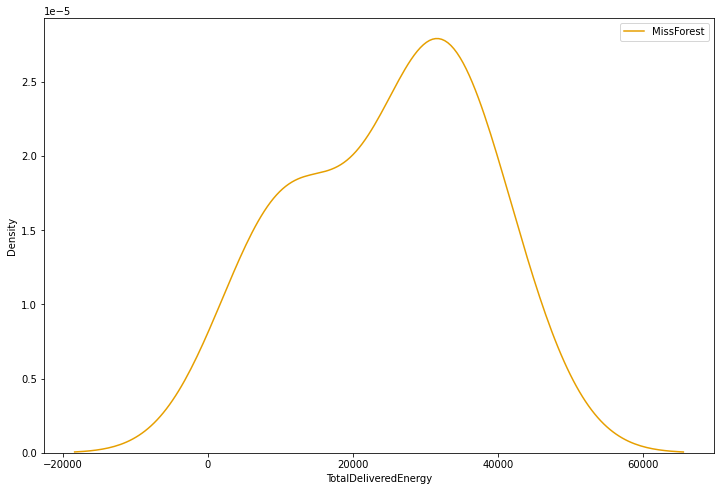

In [13]:
plt.figure(figsize=(12,8))
sns.kdeplot(x = df_sample['TotalDeliveredEnergy'][df_sample.isnull().any(axis=1)], label= 'Original', color='#009E73')
sns.kdeplot(x = imputed['TotalDeliveredEnergy'][df_sample.isnull().any(axis=1)], label = 'MissForest', color='#E69F00')
plt.legend()

In [21]:
# Impute the modal values based on grouped columns
df_sample.loc[
    df_sample['TotalDeliveredEnergy'].isna(), 'TotalDeliveredEnergy'] = df_sample.groupby(
        [
            'EnergyRating',  
            ]
        )['TotalDeliveredEnergy'].transform(
            lambda x: x.fillna(x.mean())
            )

In [22]:
df_sample['TotalDeliveredEnergyOriginal'] = df_sample_copy['TotalDeliveredEnergy']

df_sample['Stdev'] = df_sample['TotalDeliveredEnergyOriginal'].std()


# Define the error between the original and imputed values
df_sample['abs_error'] = np.abs(df_sample['TotalDeliveredEnergyOriginal'] - df_sample['TotalDeliveredEnergy'])

# Define a score metric we can use to evaluate the model
df_sample['Score'] = np.where(df_sample.abs_error < df_sample.Stdev, 1, 0)

In [23]:
df_sample

,CountyName,DwellingTypeDescr,YearofConstruction,EnergyRating,BerRating,GroundFloorArea(sq m),CO2Rating,MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,TotalDeliveredEnergyOriginal,Stdev,abs_error,Score
200087,Kilkenny,House,2008,A1,19.52,101.57,4.65,Electricity - Off-peak Night-R,Electricity - Off-peak Night-R,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,5446.38,734.44,15293.89,4711.94,1
517487,Wexford,House,2014,A1,14.03,348.40,3.15,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,80.00,8640.90,8640.90,15293.89,0.00,1
533472,Cork,House,2009,A1,24.43,224.22,0.59,Wood Pellets (bulk supply for,Wood Pellets (bulk supply for,Bal.whole mech.vent heat recvr,Timber or Steel Frame,two,Factory Insulated,50.00,2251.86,2251.86,15293.89,0.00,1
37121,Galway,House,2011,A2,49.04,222.16,11.28,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,zero,Factory Insulated,50.00,5022.15,5022.15,15293.89,0.00,1
532561,Carlow,Apartment,2005,A2,35.69,48.33,8.50,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,699.26,699.26,15293.89,0.00,1
533294,Galway,Detached house,2009,A2,47.90,259.90,11.66,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Masonry,two,Factory Insulated,50.00,7998.44,7998.44,15293.89,0.00,1
566180,Dublin,Semi-detached house,2017,A3,52.19,115.37,10.26,Electricity,Electricity,Natural vent.,Timber or Steel Frame,two,Factory Insulated,0.00,2894.63,2894.63,15293.89,0.00,1
552041,Wexford,Semi-detached house,2010,A3,66.24,118.32,15.06,Heating Oil,Heating Oil,Bal.whole mech.vent heat recvr,Timber or Steel Frame,one,Factory Insulated,50.00,5874.35,5874.35,15293.89,0.00,1
169642,Dublin,Detached house,1930,A3,69.02,340.83,16.13,Electricity,Electricity,Natural vent.,Masonry,four,Factory Insulated,35.00,12122.33,12122.33,15293.89,0.00,1
219912,Dublin,Mid-terrace house,2009,B1,89.11,127.72,17.41,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Factory Insulated,50.00,9254.50,9254.50,15293.89,0.00,1


In [24]:
1 - (abs(df_sample['Score'].sum() - df_sample['Score'].count()) / df_sample['Score'].sum())

0.9024390243902439

In [33]:
from sklearn.metrics import r2_score

r2_score(df_sample['TotalDeliveredEnergyOriginal'], df_sample['TotalDeliveredEnergy'])

0.6381880316766841

In [34]:
from sklearn.metrics import  mean_squared_error

np.sqrt(mean_squared_error(df_sample['TotalDeliveredEnergyOriginal'], df_sample['TotalDeliveredEnergy']))

9096.607669901668

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


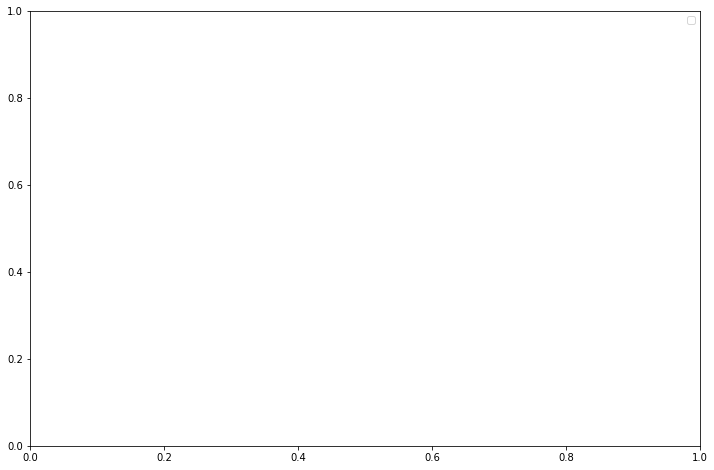

In [25]:
plt.figure(figsize=(12,8))
sns.kdeplot(x = df_sample['TotalDeliveredEnergy'][df_sample.isnull().any(axis=1)], label = 'Original', color = '#009E73')
sns.kdeplot(x = df_sample_copy['TotalDeliveredEnergy'][df_sample.isnull().any(axis=1)], label= 'Grouped Mean/Mode', color = '#E69F00')
plt.legend()

As we can see above out of our samples, the majority were within a single standard deviation of the original. A couple were above.

If we take this to be our accuracy on this hypothesis test, we have a very high accuracy in our tests. For those within the standard deviation, they are very low in margin of error which is great. It is never going to be 100% accurate as we can see with the single outlier which we need to watch out for and perhaps check for after the fact. In majority it works perfectly for our needs.

In [ ]:
import matplotlib
matplotlib.pyplot.figure(figsize=(12,8))

---

#### 2.5 Report

In [85]:
# Create a pandas profile report
profile_optimised = ProfileReport(seai_imputed, title="SEAI Data Cleaned & Imputed Report", explorative=True)
# Output the report to a html file to view
profile_optimised.to_file("../reports/Define/3-seai_miss_forest_imputation.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 150.51it/s]


In [84]:
# inspect final output
seai_imputed

,CountyName,DwellingTypeDescr,YearofConstruction,GroundFloorArea(sq m),MainSpaceHeatingFuel,MainWaterHeatingFuel,VentilationMethod,StructureType,NoOfSidesSheltered,InsulationType,InsulationThickness,TotalDeliveredEnergy,EnergyRating
0,Donegal,Detached house,1997,171.19,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,20.00,25474.52,C2
1,Kildare,Detached house,2010,242.93,Heating Oil,Heating Oil,Natural vent.,Masonry,two,Factory Insulated,50.00,27654.47,B3
2,Dublin,Semi-detached house,1999,99.38,Mains Gas,Mains Gas,Natural vent.,Masonry,three,Loose Jacket,20.00,17000.04,C3
3,Dublin,Semi-detached house,1965,138.41,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Factory Insulated,39.35,22708.48,C2
4,Dublin,Semi-detached house,1985,127.16,Mains Gas,Mains Gas,Natural vent.,Masonry,two,Loose Jacket,100.00,28182.86,D2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005340,Dublin,Mid-floor apartment,2020,37.80,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,four,Factory Insulated,32.03,2279.82,A3
1005342,Dublin,Mid-floor apartment,2020,86.58,Electricity,Electricity,Bal.whole mech.vent heat recvr,Masonry,three,None,9.84,5843.38,A2
1005343,Donegal,Detached house,1982,214.18,Heating Oil,Heating Oil,Natural vent.,Masonry,one,Factory Insulated,35.24,52927.53,D2
1005344,Dublin,Mid-terrace house,1900,99.77,Manufactured Smokeless Fuel,Electricity,Natural vent.,Masonry,four,None,14.52,40838.47,G


---